# Dpi Setting

In [165]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100 # 300

In [166]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [167]:
from package_sampling.sampling import up_tille, up_brewer, up_systematic, up_max_entropy
from package_sampling.utils import inclusion_probabilities


### Dependencies

### Python

In [168]:
# !pip install -q git+https://github.com/mehdimhb/geometric-sampling@dev
# !pip install git+https://github.com/mehdimhb/geometric-sampling@legacy-measure

In [169]:
!apt-get install -y r-base
!pip install -q rpy2 tqdm


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?

[notice] A new release of pip is available: 25.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [170]:
from rpy2.robjects.packages import importr


In [171]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


### R

In [172]:
%%R

#library(spcosa)
#ibrary(spsurvey)
if(!require(WaveSampling)){
    install.packages("WaveSampling")
    library(WaveSampling)
}
if(!require(sampling)){
    install.packages("sampling")
    library(sampling)
}
if(!require(BalancedSampling)){
    install.packages("BalancedSampling")
    library(BalancedSampling)
}

### Imports

In [173]:
import matplotlib as mpl
import numpy as np
from rpy2.robjects import r, numpy2ri
import rpy2.robjects as ro
from matplotlib import pyplot as plt
from itertools import combinations
from collections import OrderedDict
import pandas as pd
import geometric_sampling as gs
from tqdm import tqdm
from tqdm.contrib import tenumerate
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

numpy2ri.activate()

rng = gs.random.rng()

## Functions

### Scores in R

In [174]:
def scores(coords, probs, n, N, sample_idx, split_size, density_measure=None):
    assert len(coords) == len(probs) == N
    assert len(sample_idx) == n
    sample_mask = np.zeros(N, dtype=int)
    sample_mask[sample_idx] = 1

    ro.globalenv['sample_mask'] = sample_mask
    ro.globalenv['sample_idx'] = sample_idx + 1
    ro.globalenv['coords'] = coords
    ro.globalenv['probs'] = probs
    ro.globalenv['n'] = n
    ro.globalenv['N'] = N
    #ro.globalenv['split_size'] = split_size


    r_code = """
W <- wpik(coords,probs)
W <- W - diag(diag(W))
diag(W) <- 0  # Ensure W has zero diagonal


ib_value <- tryCatch({
  IB(W, sample_mask)  # Moran's Index
}, error = function(e) {
  Inf
})

sb_value <- tryCatch({
  sb(probs, coords, sample_idx)  # Spatial balance
}, error = function(e) {
  Inf
})

sblb_value <- tryCatch({
  sblb(probs, coords, sample_idx)  # Spatial balance using local balance
}, error = function(e) {
  Inf
})
"""
    ro.r(r_code)
    IB_value = ro.r("ib_value")[0]
    SBLB_value = ro.r("sblb_value")[0]
    if density_measure is None:
      scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
      density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    scores, _ = density_measure.score(sample_idx.reshape(1, -1))
    return scores[0][0], IB_value, SBLB_value
    

### Functions

# Simulations

### Methods

In [177]:
import numpy as np
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri

# Enable the numpy <-> R conversion
rpy2.robjects.numpy2ri.activate()
def k_means_samples(coords, probs, n, num_samples, n_zones):
    # Placeholder, replace with your actual method if necessary
    return gs.sampling.KMeansSpatialSamplingSimple(coords, probs, n=n, n_zones=n_zones, tolerance=6, split_size=0.001).sample(num_samples)

def find_samples(coords, probs, n, num_samples, ep_mode="auto"):
    """
    Returns a dict of various sampling methods. 
    If ep_mode=="auto", heuristically deduce EP/UP from probs.
    """
    result = {
        # "K-Means (12)": k_means_samples(coords, probs, n, num_samples, (1, 2)),
        # "K-Means (21)": k_means_samples(coords, probs, n, num_samples, (2, 1)),
        "K-Means (33rand)": k_means_samples(coords, probs, n, num_samples, (3, 3)),
        #"K-Means (11)": k_means_samples(coords, probs, n, num_samples, (1, 1)),

    }
    return result

In [178]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

folder = "/home/divar/projects/geometric-sampling/data_samples/coords_probs"
results_folder = "/home/divar/projects/geometric-sampling/data_samples/results"
os.makedirs(folder, exist_ok=True)

all_coords = []
all_probs = []
names = [
    "clust_eq", "clust_uneq",
    "grid_eq", "grid_uneq",
    "random_eq", "random_uneq"
]

for name in names:
    df = pd.read_csv(f"/home/divar/projects/geometric-sampling/data_samples/coords_probs/{name}.csv")
    coords = df[["x", "y"]].values
    probs = df["prob"].values
    all_coords.append(coords)
    all_probs.append(probs)

sample_cnt = 1000
columns = ["Method", "Density", "Moran", "Local Balanced"]

for coords, probs, name in zip(all_coords, all_probs, names):
    n = int(np.round(np.sum(probs)))
    N = len(probs)
    # Your sampling, e.g.:
    sample_methods = find_samples(coords, probs, n, sample_cnt)
    scaled_coords = (coords - np.min(coords, axis=0)) / np.ptp(coords, axis=0)
    density_measure = gs.measure.Density(scaled_coords, probs, n, split_size=0.001)
    
    rows = np.array([
        [method, *scores(coords, probs, n, N, s, density_measure)]
        for method, samples in sample_methods.items()
        if samples is not None
        for s in tqdm(samples, total=sample_cnt)
    ])
    
    df = pd.DataFrame(rows, columns=columns)
    df = df.astype({
        "Density": float,
        "Moran": float,
        "Local Balanced": float
    })
    # Save to cleaned results file
    filename = os.path.join(results_folder, f"cleaned_results_{name}.csv")
    df.to_csv(filename, mode='a', index=False, header=False)
    print(f"Appended to: {filename}")

100%|██████████| 1000/1000 [23:07<00:00,  1.39s/it]


Appended to: /home/divar/projects/geometric-sampling/data_samples/results/cleaned_results_clust_eq.csv


100%|██████████| 1000/1000 [16:13<00:00,  1.03it/s]


Appended to: /home/divar/projects/geometric-sampling/data_samples/results/cleaned_results_clust_uneq.csv


100%|██████████| 1000/1000 [19:24<00:00,  1.16s/it]


Appended to: /home/divar/projects/geometric-sampling/data_samples/results/cleaned_results_grid_eq.csv


100%|██████████| 1000/1000 [30:16<00:00,  1.82s/it]


Appended to: /home/divar/projects/geometric-sampling/data_samples/results/cleaned_results_grid_uneq.csv


100%|██████████| 1000/1000 [18:48<00:00,  1.13s/it]


Appended to: /home/divar/projects/geometric-sampling/data_samples/results/cleaned_results_random_eq.csv


100%|██████████| 1000/1000 [26:30<00:00,  1.59s/it]

Appended to: /home/divar/projects/geometric-sampling/data_samples/results/cleaned_results_random_uneq.csv


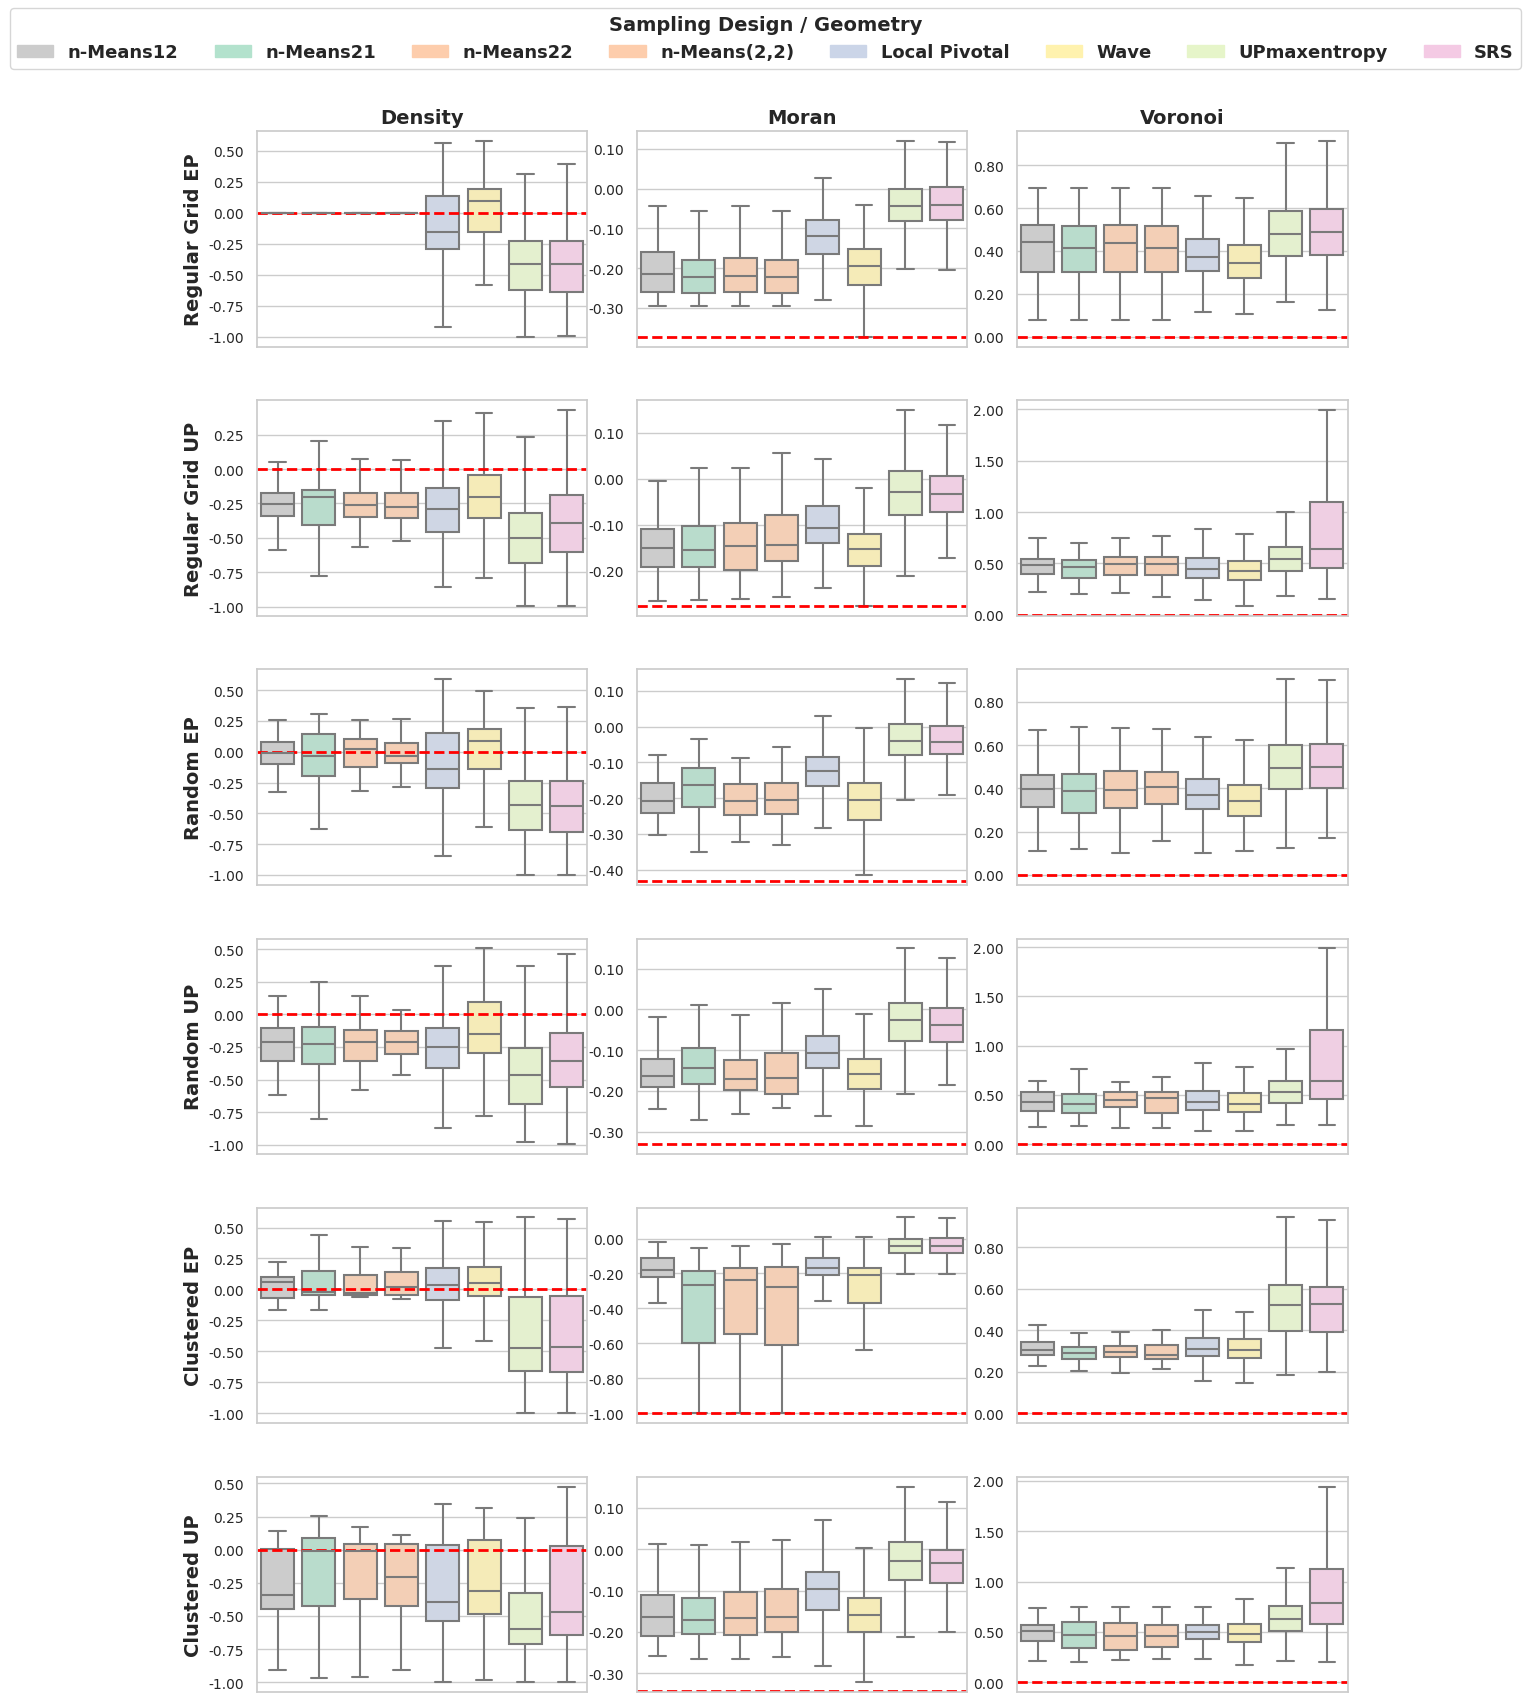

In [54]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

sns.set(style="whitegrid")

# Folder and file info
results_folder = '/home/divar/projects/geometric-sampling/data_samples/results'
result_files = [
    "cleaned_results_grid_eq.csv",
    "cleaned_results_grid_uneq.csv",
    "cleaned_results_random_eq.csv",
    "cleaned_results_random_uneq.csv",
    "cleaned_results_clust_eq.csv",
    "cleaned_results_clust_uneq.csv",
]

pretty_names = {
    "grid_eq": "Regular Grid EP",
    "grid_uneq": "Regular Grid UP",
    "random_eq": "Random EP",
    "random_uneq": "Random UP",
    "clust_eq": "Clustered EP",
    "clust_uneq": "Clustered UP",
}

# For display
pop_names = [s.replace("cleaned_results_", "").replace(".csv", "") for s in result_files]

# Mapping for all names (methods and shapes!)
method_name_mapping = {
    "K-Means (1, 1)": "n-Means",
    "K-Means (12)": "n-Means12",
    "K-Means (21)": "n-Means21",
    "K-Means (22)": "n-Means22",
    "K-Means (3, 3)": "n-Means(2,2)",
    "Local Pivotal": "Local Pivotal",
    "Random": "SRS",
    "UPmaxentropy": "UPmaxentropy",
    "wave": "Wave",
    "cube": "Cube"
}
# desired consistent plotting order
method_order = [
     "n-Means12","n-Means21","n-Means22", "n-Means(2,2)", "Local Pivotal", "Wave", "UPmaxentropy", "SRS", 
]

# Read results into a dict, fix column names
results_dict = {}
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname), header=None)
    # Name columns the same way as in cleaning script
    df.columns = ["Method", "Density", "Moran", "Local Balanced"]
    # Map pretty method names (including shapes)
    df["Method"] = df["Method"].map(method_name_mapping)
    results_dict[name] = df

# All method labels present
all_methods = pd.concat(list(results_dict.values()))["Method"].unique()
method_palette = dict(zip(all_methods, sns.color_palette("Pastel2", n_colors=len(all_methods))))
# Metrics (ensure correct order: Density, Moran, Local Balanced)
for name, fname in zip(pop_names, result_files):
    df = pd.read_csv(os.path.join(results_folder, fname), header=None)
    df.columns = ["Method", "Density", "Moran", "Local Balanced"]
    df.rename(columns={"Local Balanced": "Voronoi"}, inplace=True)
    df["Method"] = df["Method"].map(method_name_mapping)
    results_dict[name] = df

columns = ["Density", "Moran", "Voronoi"]
# Create 6 populations x 3 metrics grid
n_rows = len(pop_names)
n_cols = len(columns)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), sharey=False)

for row_idx, pop in enumerate(pop_names):
    df_pop = results_dict[pop]
    for col_idx, metric in enumerate(columns):
        ax = axes[row_idx, col_idx]
        sns.boxplot(
            x="Method",
            y=metric,
            data=df_pop[df_pop[metric].astype(float) < 2],  # filter big outliers if any
            hue="Method",
            palette=method_palette,
            ax=ax,
            order=method_order,
            showfliers=False,
            linewidth=1.5,
        )
        ax.tick_params(axis='x', length=0)
        if row_idx == 0:
            ax.set_title(f"{metric}", fontsize=14, weight='bold')
        else:
            ax.set_title("")
        if col_idx == 0:
            ax.set_ylabel(pretty_names.get(pop, pop), weight='bold', fontsize=14)
        else:
            ax.set_ylabel("")
        ax.set_xlabel("")
        ax.set_xticklabels([])
        if not (row_idx == 0 and col_idx == 0):
            legend = ax.get_legend()
            if legend is not None:
                legend.remove()
        ax.tick_params(axis='y', labelsize=10)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))  # 2 decimals
        if metric == "Moran":
            ax.axhline(y=min(df_pop['Moran']), color='red', linestyle='--', linewidth=2)
        else:
            ax.axhline(y=0, color='red', linestyle='--', linewidth=2)

# Shared legend
from matplotlib.patches import Patch
df_concat = pd.concat(list(results_dict.values()), ignore_index=True)
labels = [m for m in method_order if m in all_methods]
handles = [Patch(color=method_palette[m]) for m in labels]

leg = fig.legend(
    handles, labels, loc='upper center', ncol=len(method_order),
    title="Sampling Design / Geometry", fontsize=13, title_fontsize=14
)
for text in leg.get_texts():
    text.set_fontweight('bold')
leg.get_title().set_fontweight('bold')

fig.tight_layout(rect=[0, 0.05, 1, 0.95])
fig.subplots_adjust(wspace=0.15, hspace=0.25)
plt.show()